# 2022-09-13 Bernstein Conference

## Creating input

In [1]:
from bernstein import make_input, plot_input, cospattern, linear, vonmises

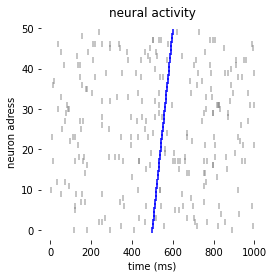

In [2]:
nb_synapses, noise_density, simulation_time, t_true = 50, 5e-3, 1e3, .5e3
pattern_temporal_amplitude = 100
pattern = linear

aer_noise, aer_pattern, aer_both = make_input(nb_synapses, noise_density, simulation_time, pattern_temporal_amplitude, t_true, function=pattern)
fig, ax = plot_input(aer_noise, aer_pattern)

## A leaky Integrate and fire neurons implemented in an event-based fashion

In [3]:
from bernstein import hsd_neuron, plot_hsd_response

$V(t) = V_{rest} + \gamma \cdot (V_\theta-V_{rest}) \cdot \sum_{s} \omega_s \sum_{r \in \epsilon_{pre}} K_s(t, t_r) - \sum_{f \in \epsilon_{post}} (V_\theta-V_{rest}) \cdot e^{-\frac{t - t_r}{\tau}}$

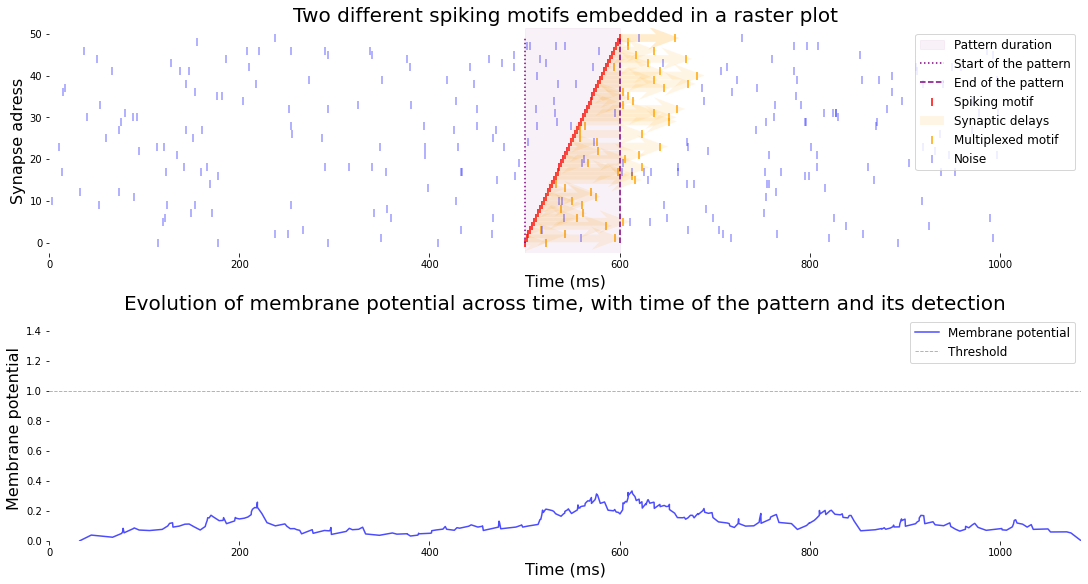

In [4]:
gain = 1
tau = 20
delay_amplitude = pattern_temporal_amplitude

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

V, sorted_times, sorted_addresses, t_out = N.code(aer_both)

fig_neuron, axs_neuron = plot_hsd_response(sorted_times, sorted_addresses, V, N, t_true, t_out, delay_amplitude, aer_noise, aer_pattern)

### Change of the time constant of the neuron

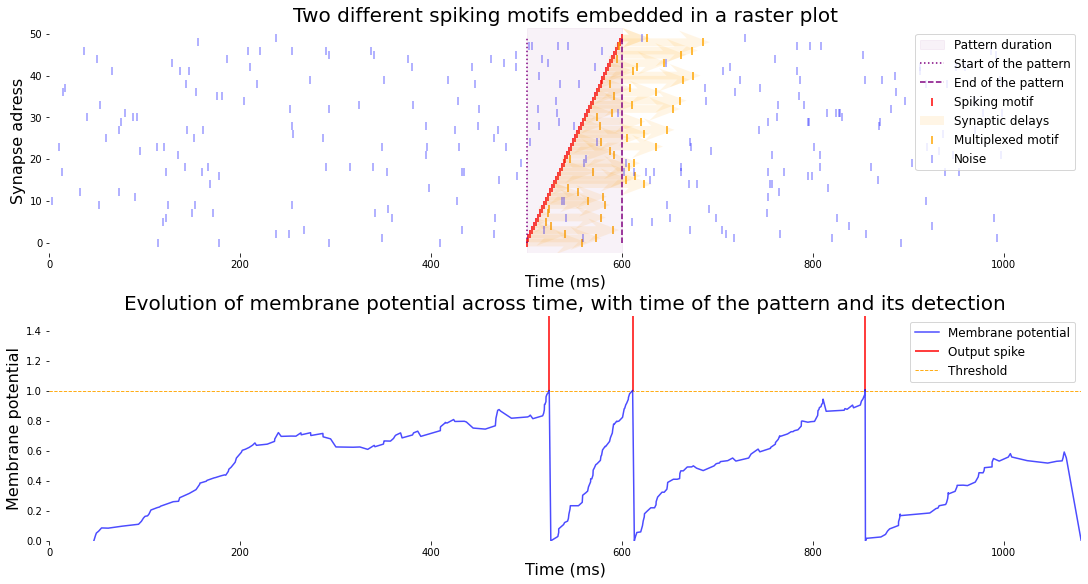

In [5]:
gain = 1
tau = 200
delay_amplitude = pattern_temporal_amplitude

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

V, sorted_times, sorted_addresses, t_out = N.code(aer_both)

fig_neuron, axs_neuron = plot_hsd_response(sorted_times, sorted_addresses, V, N, t_true, t_out, delay_amplitude, aer_noise, aer_pattern)

## Unsupervised learning of the delays obtained by derivating the membrane potential 

We compute the membrane potential (V) with a gaussian kernel for the first computations. Then we will pass to causal kernel
Then, we can compute the gradient of V at the time of the output spike and adjust the delays to maximize V at the output spike time. 
We set an adjustment of the gain to keep the firing rate constant (prior knowledge). The neuron will spiek one time during simulation time. 

In [6]:
from bernstein import plot_learning_figure, absolute_kernel, gaussian_kernel
import numpy as np

99


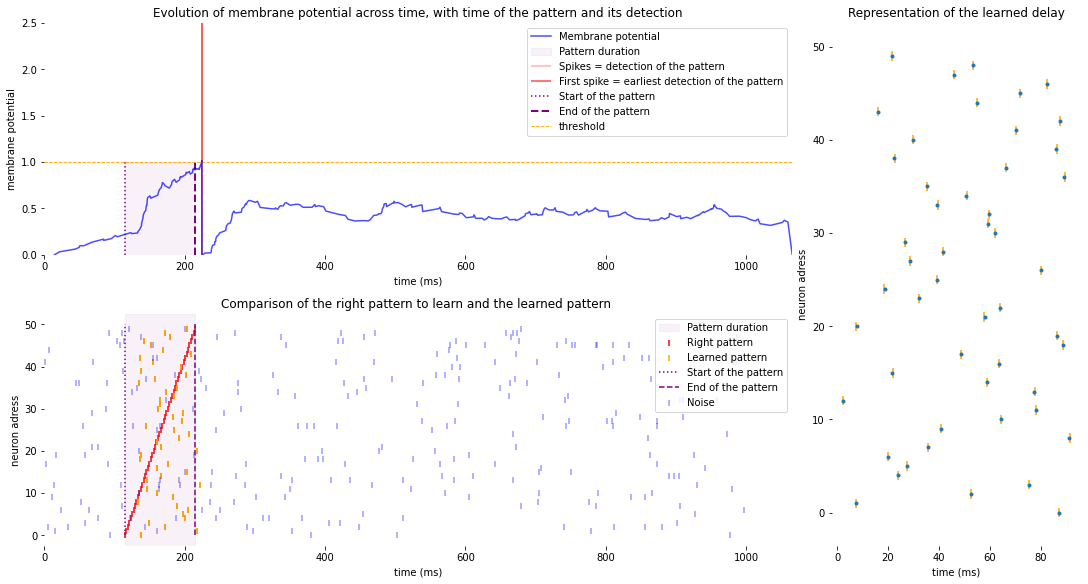

91


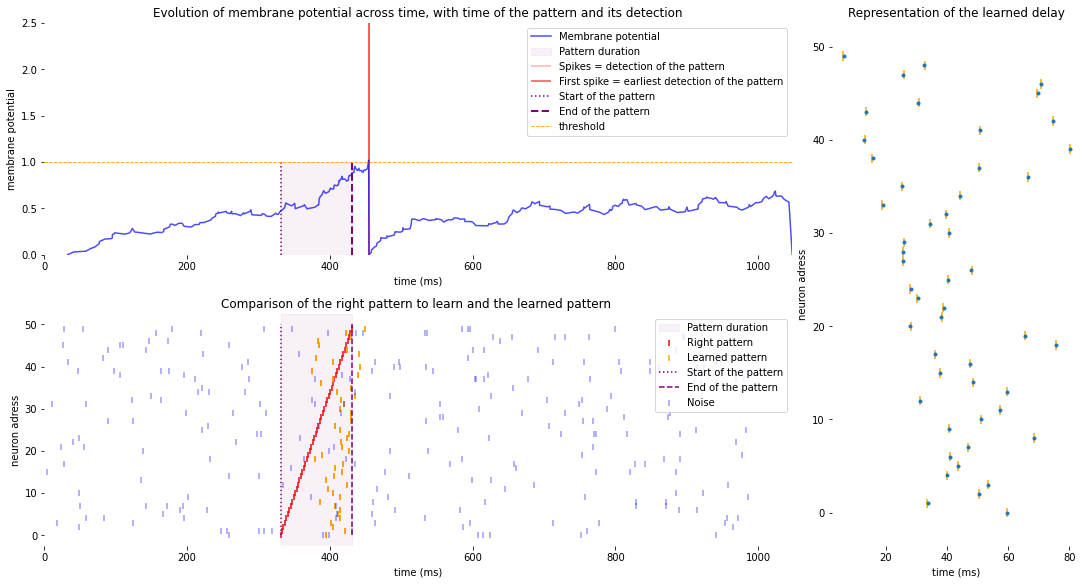

87


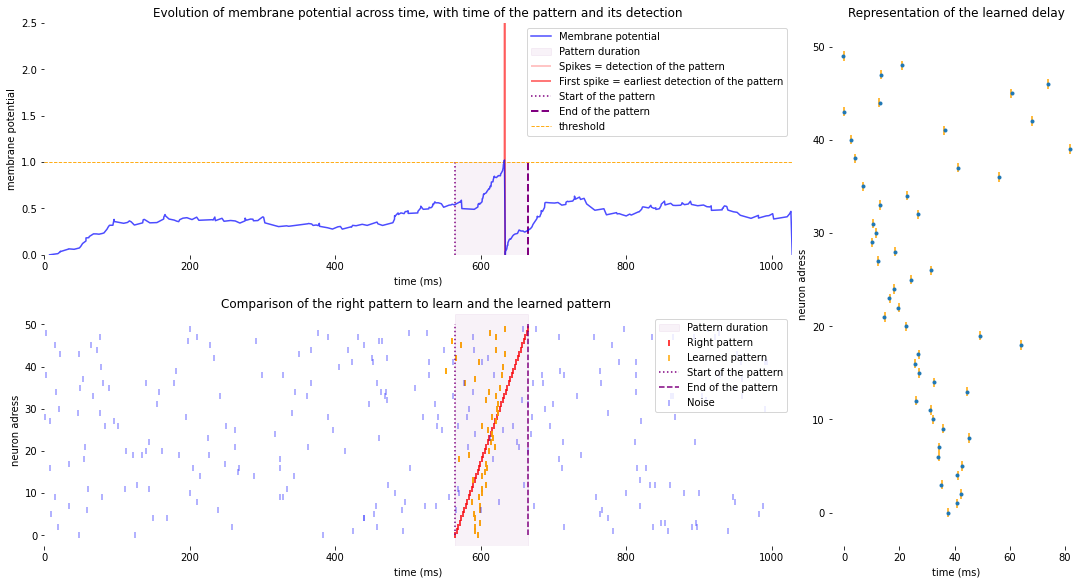

81


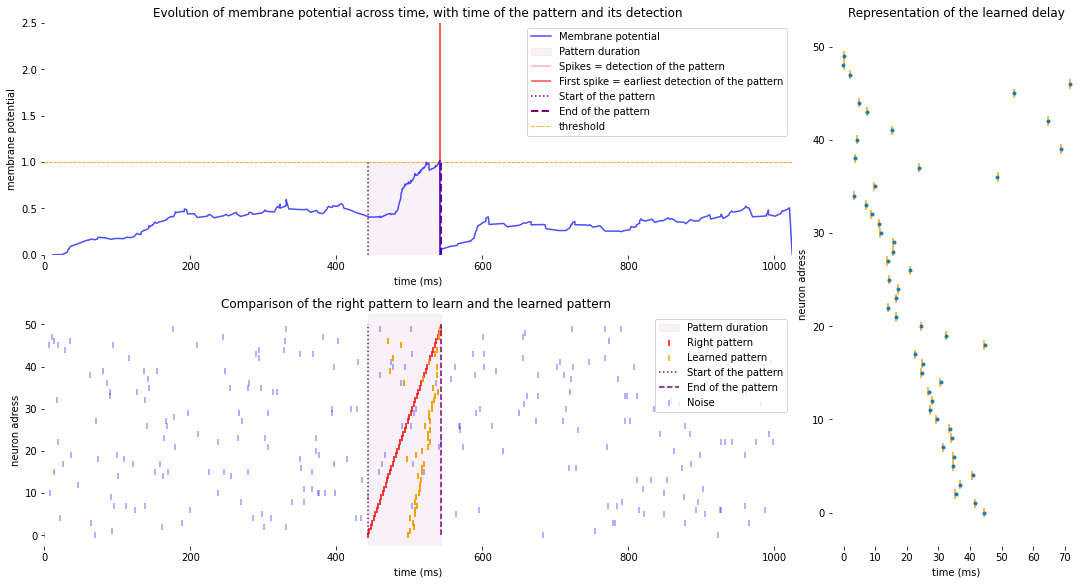

81


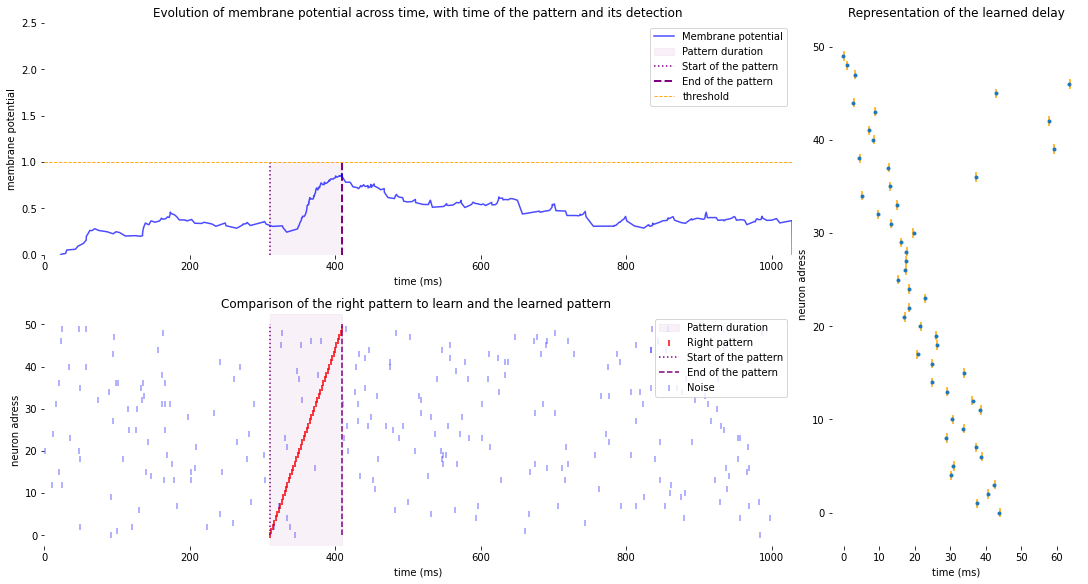

75


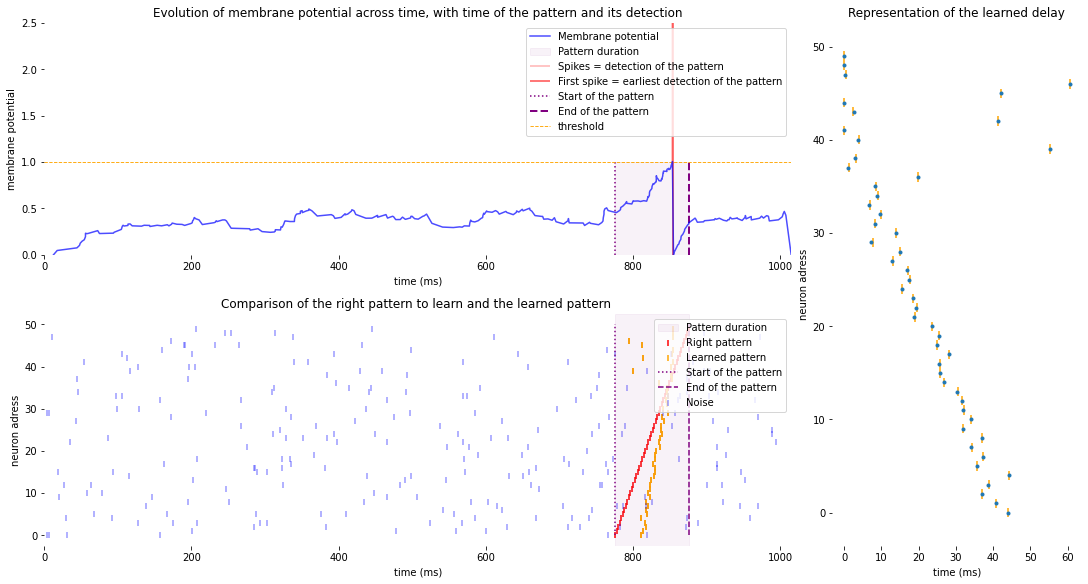

71


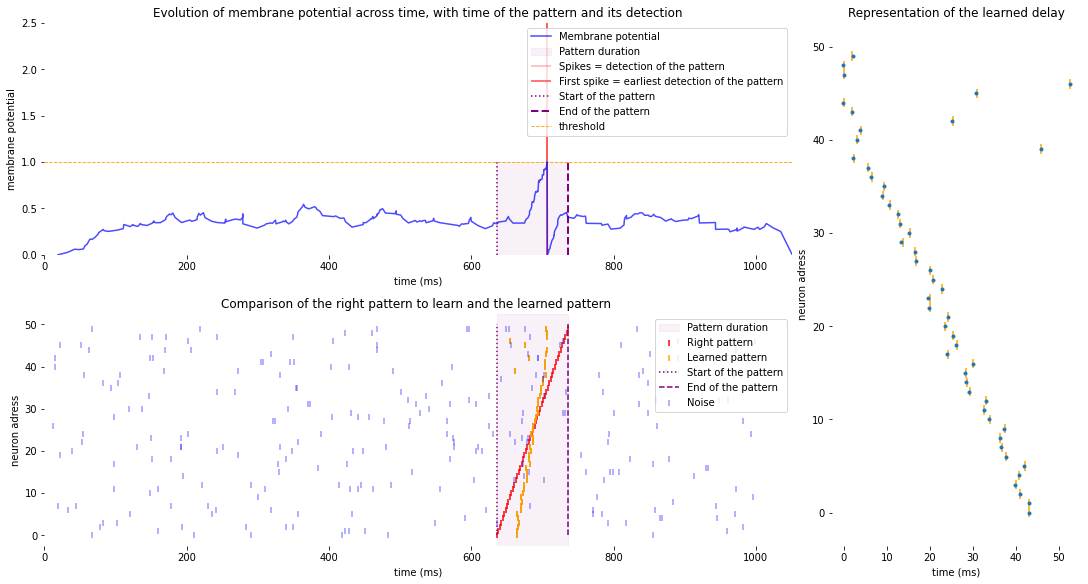

71


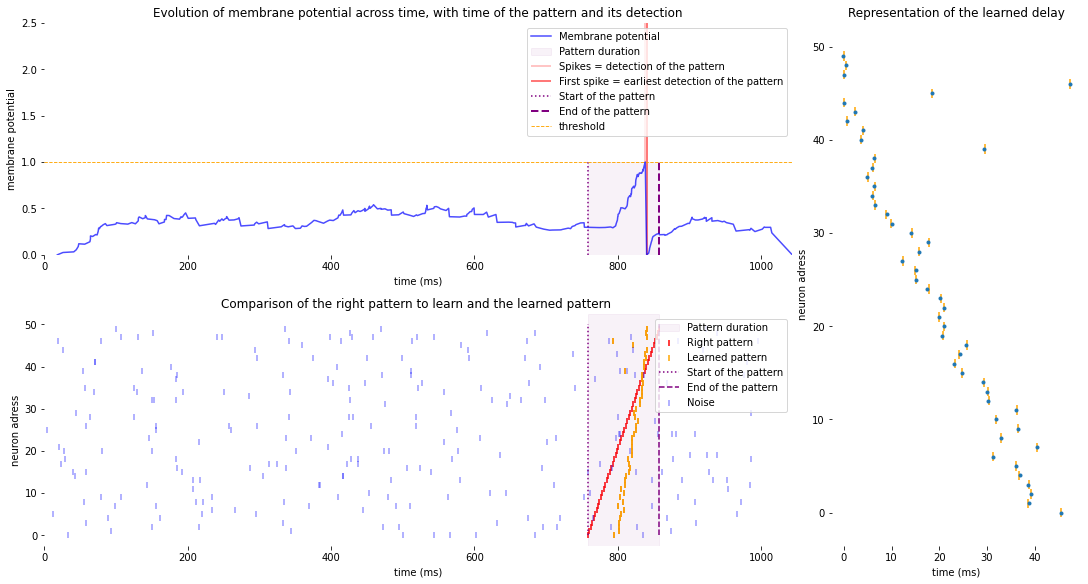

69


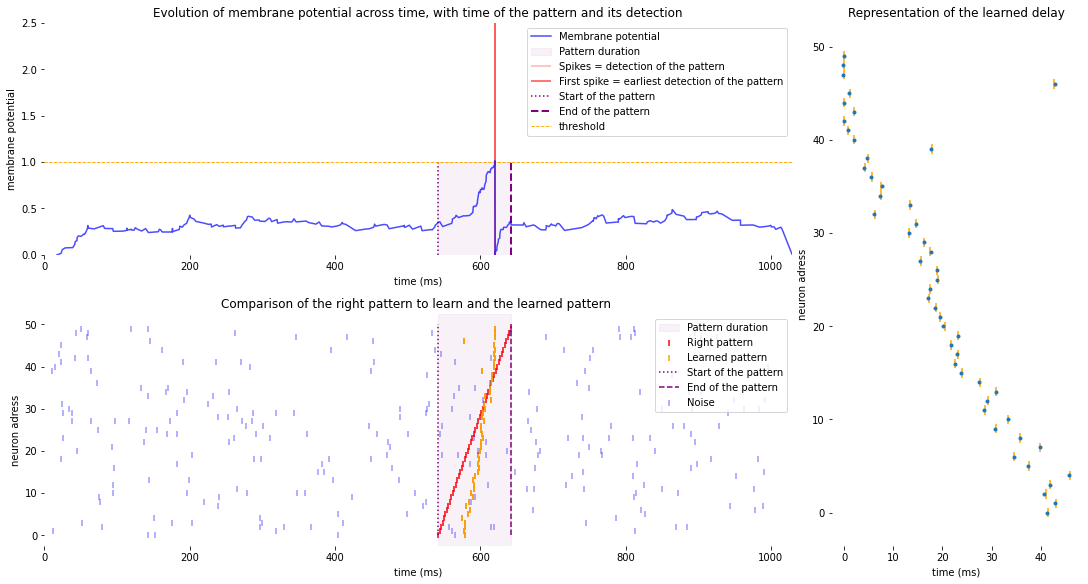

69


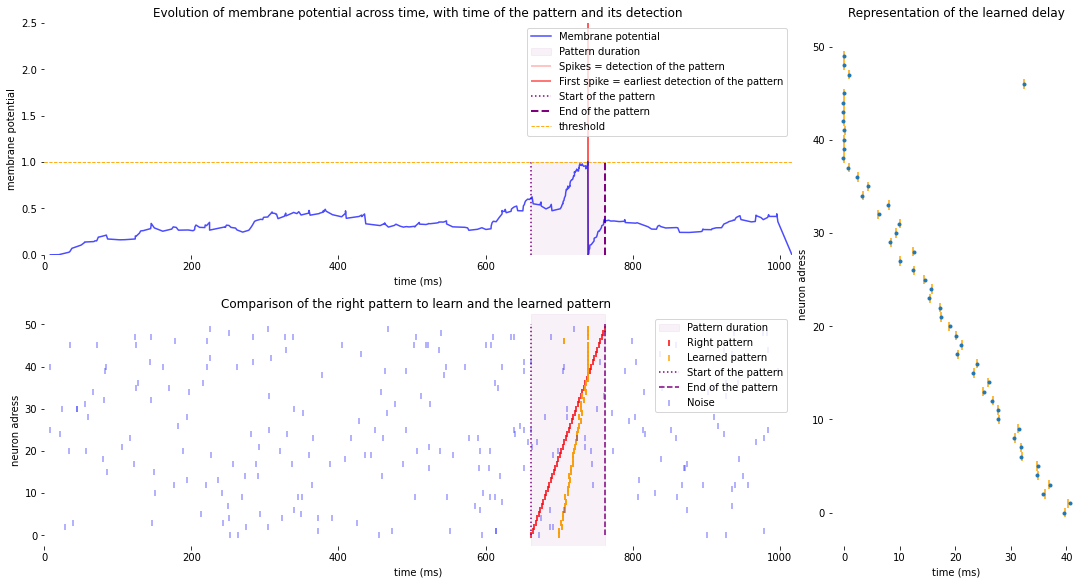

73


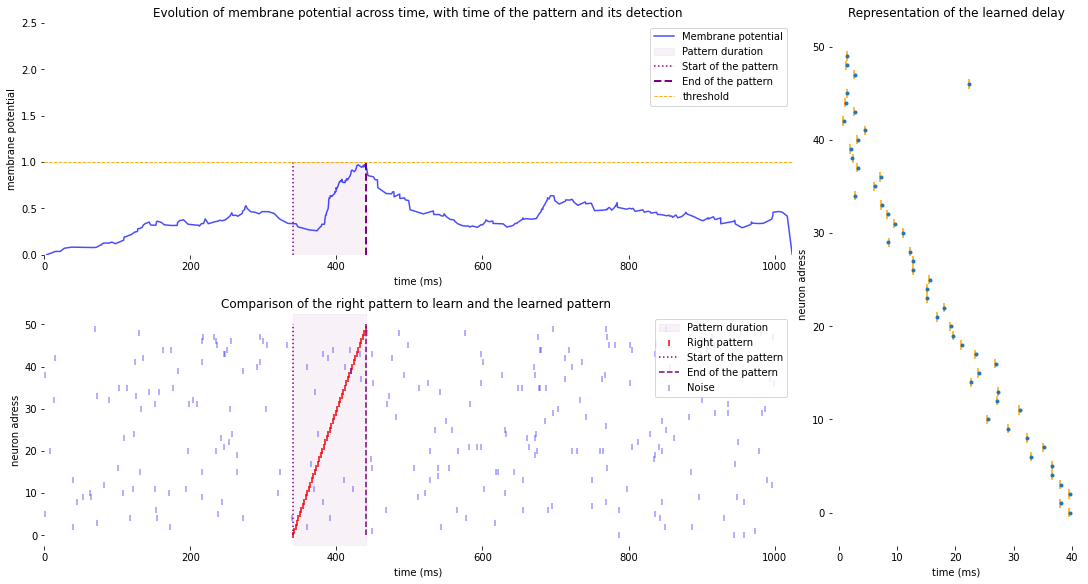

In [10]:
tau = delay_amplitude
gain = 1

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

noise_density =  5e-3
learning_rate_gain = .01
learning_rate_tau = 1
learning_rate_delay = .1
N_epochs = 501

for i_epoch in range(N_epochs):
    t_true = delay_amplitude + int(np.random.rand()*(simulation_time-3*delay_amplitude))

    aer_noise, aer_pattern, aer = make_input(nb_synapses, noise_density, simulation_time, delay_amplitude, t_true, function = pattern)
    V, sorted_times, sorted_addresses, t_out = N.code(aer)

    output_spikes_number = len(t_out)
    expected_output_spikes = len([t_true])
    
    if output_spikes_number==0:
        #print(N.gain)
        #N.gain += learning_rate_gain*expected_output_spikes
        N.tau += learning_rate_tau*expected_output_spikes
    else:
        for t_post in t_out:
            V_out = V[sorted_times==t_post]
            delay_gradient = np.zeros([len(N.delays)])
            for add in range(len(N.delays)):
                spike_times = sorted_times[np.where(sorted_addresses==add)[0]]
                if len(spike_times)>0:
                    delta_delay = t_post-N.delays[add]-spike_times[spike_times<t_post+delay_amplitude]
                    delay_function = np.sign(delta_delay)*absolute_kernel(delta_delay, N.tau)
                    #delay_function = delta_delay*gaussian_kernel(delta_delay, N.tau)
                    delay_gradient[add] = (delay_function).sum()
                
            if np.linalg.norm(delay_gradient)!=0:
                delay_gradient /= np.linalg.norm(delay_gradient)
            N.delays += learning_rate_delay*delay_gradient*delay_amplitude
            N.delays[N.delays<0]=0
        
        #N.gain += learning_rate_gain*(expected_output_spikes-output_spikes_number)
        N.tau += learning_rate_tau*(expected_output_spikes-(output_spikes_number+1))
    if i_epoch % (N_epochs//10) == 0:
        print(N.tau)
        plot_learning_figure(sorted_times, V, N, t_out, t_true, delay_amplitude, aer_noise, aer_pattern, delay_gradient=delay_gradient)

All 3 patterns are detected and the delays are converging with this method. Here we adapt the time constant and not the gain. But there is a problem with the delay values. It seems to come from the normalization of the delays with the quadratic norm. To be corrected.

0.99


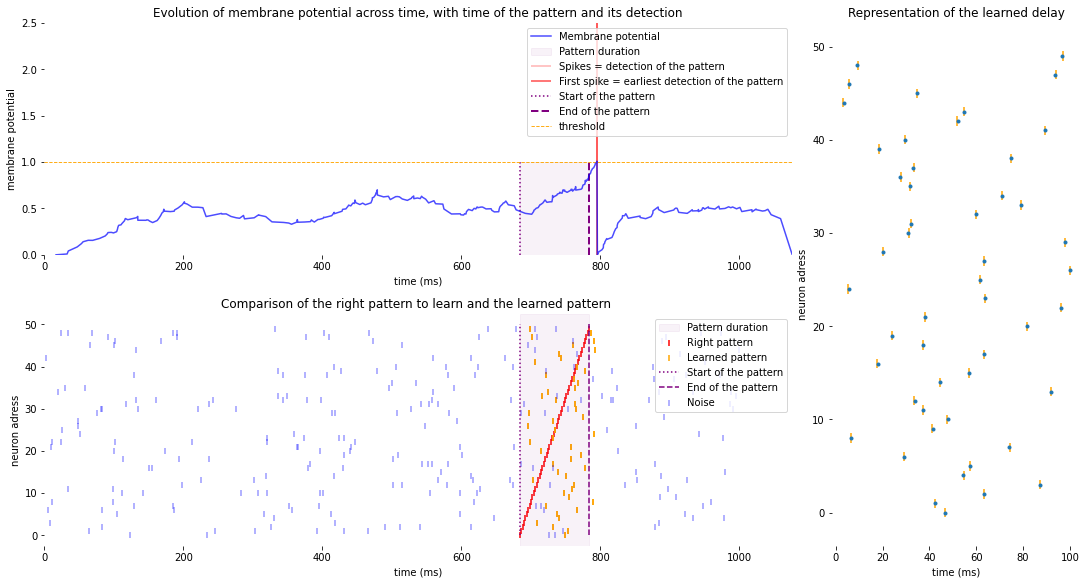

0.8499999999999999


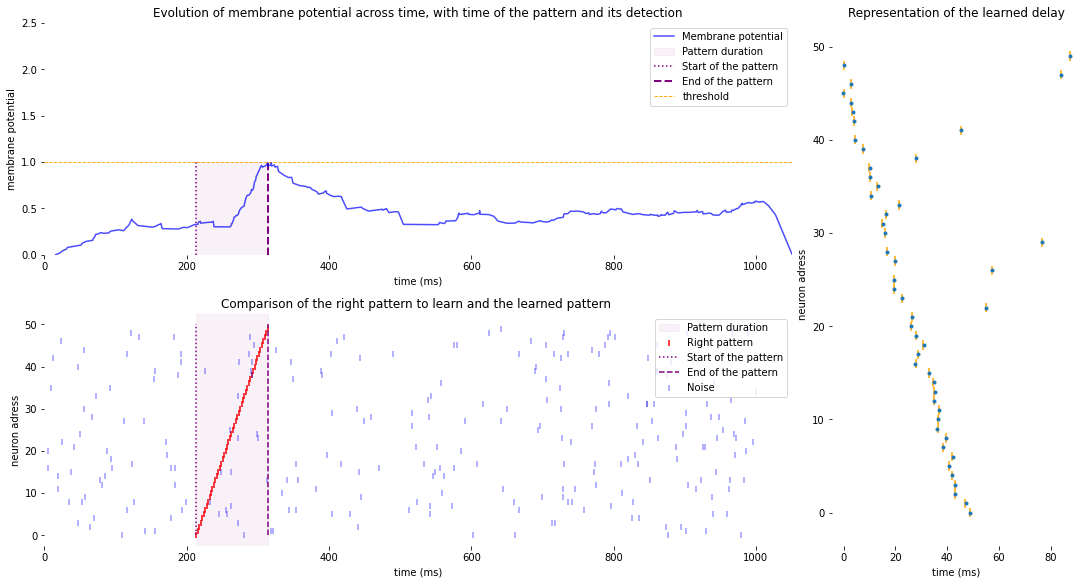

0.7899999999999998


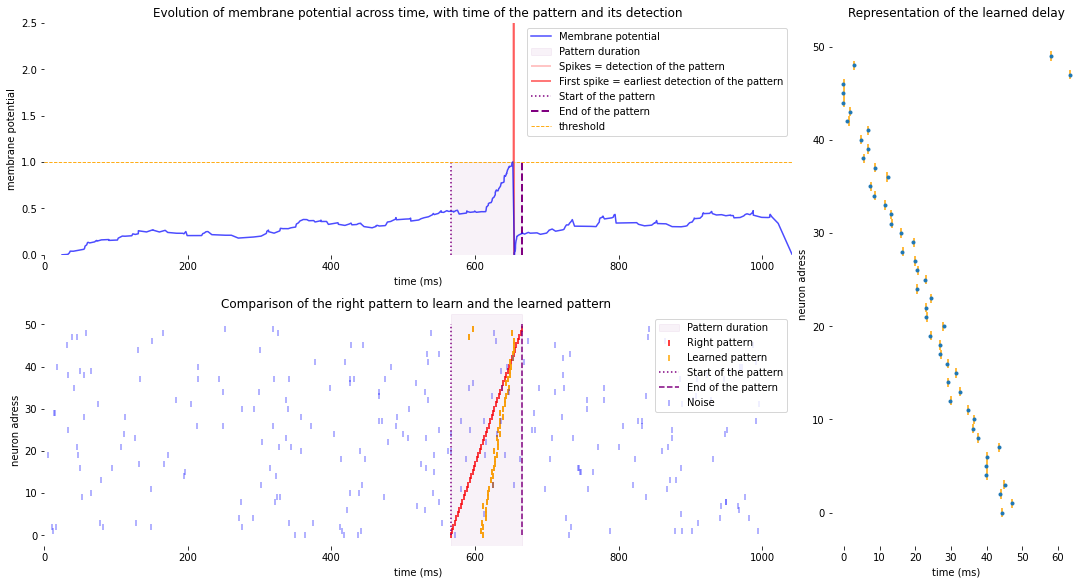

0.8099999999999998


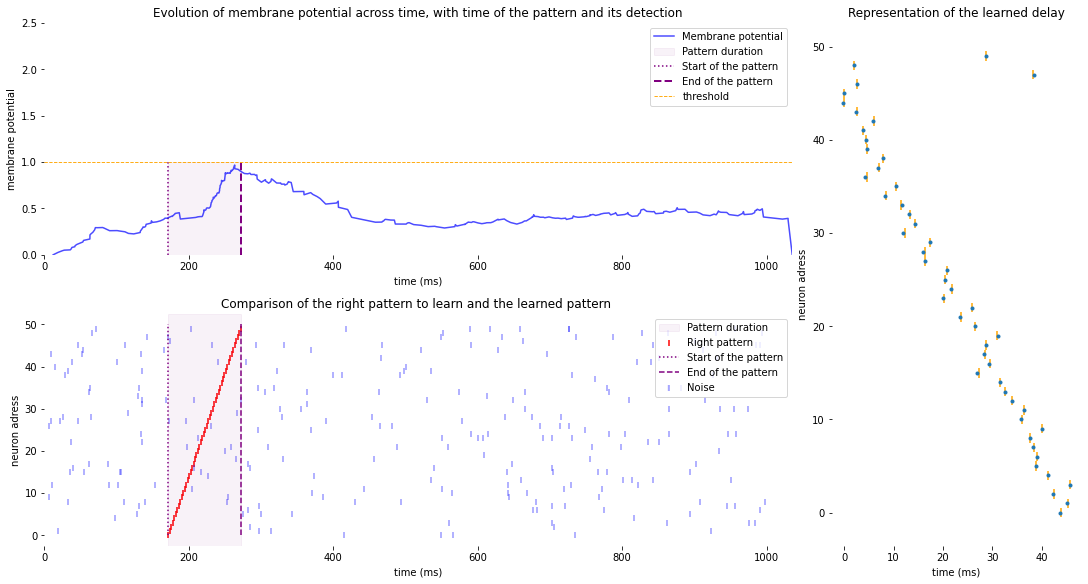

0.7899999999999998


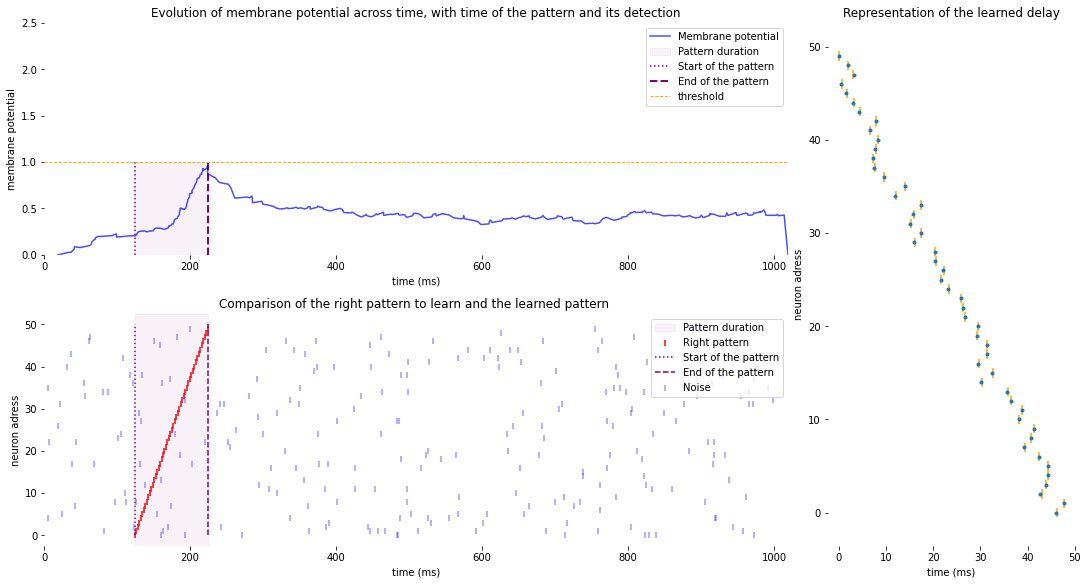

0.7699999999999998


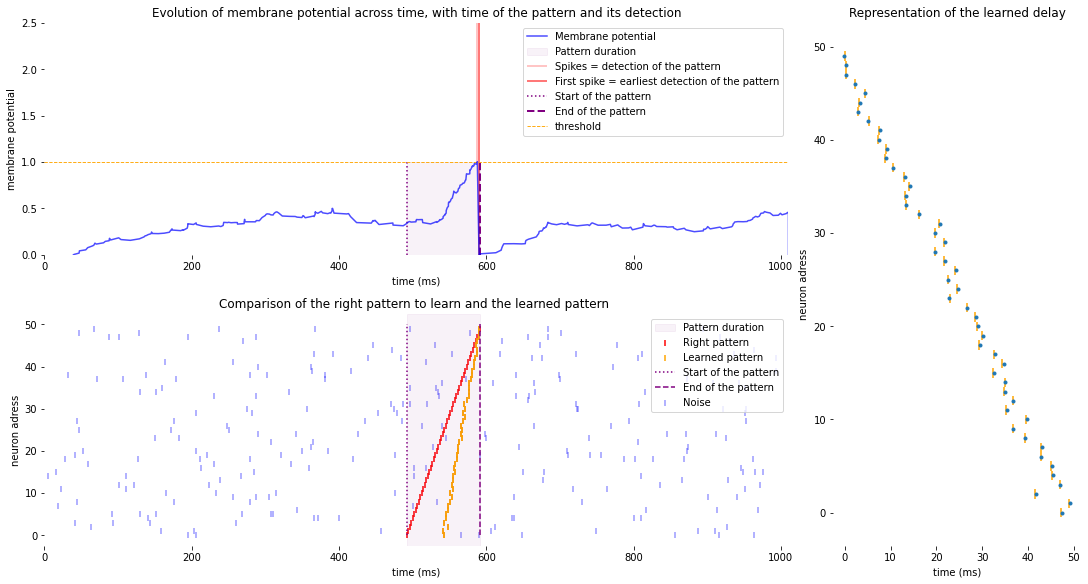

0.7899999999999998


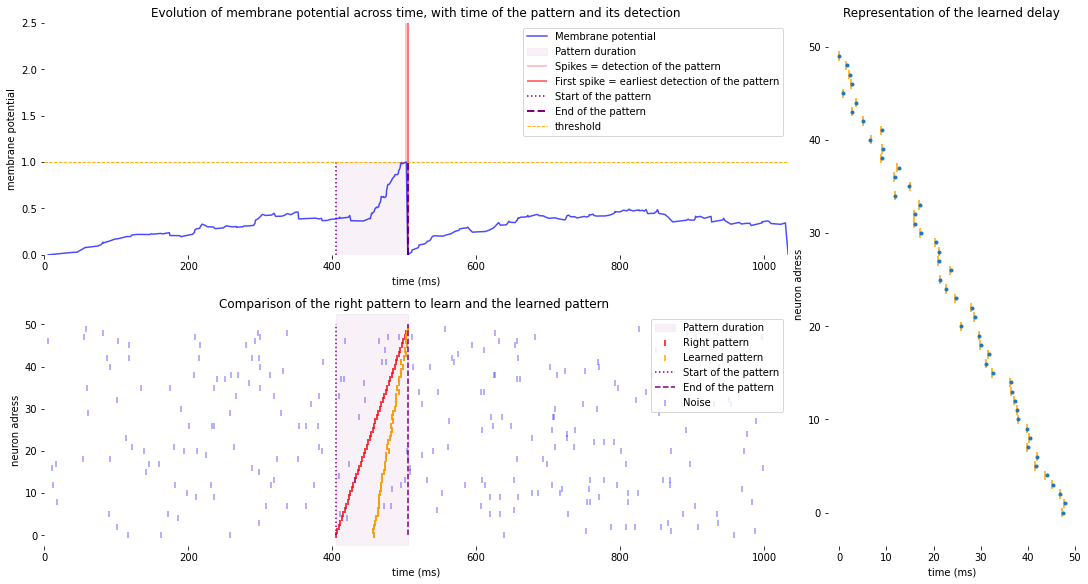

0.7899999999999998


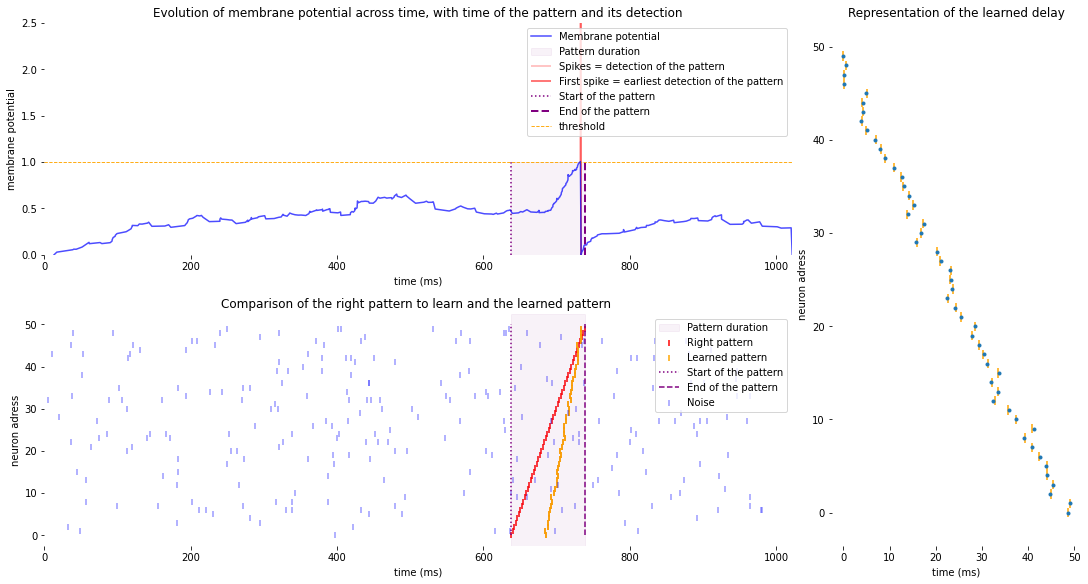

0.8099999999999998


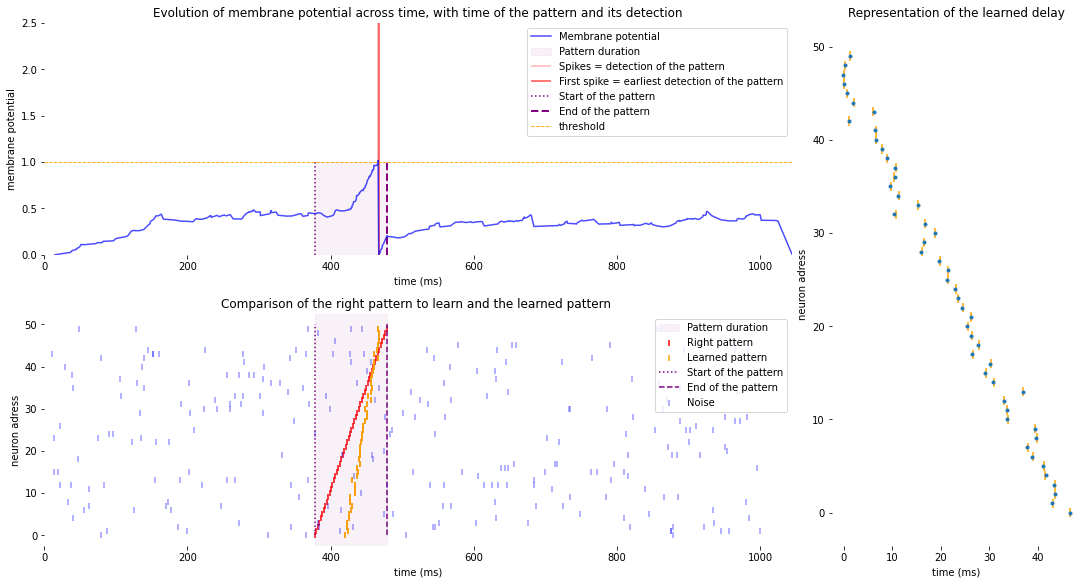

0.7299999999999998


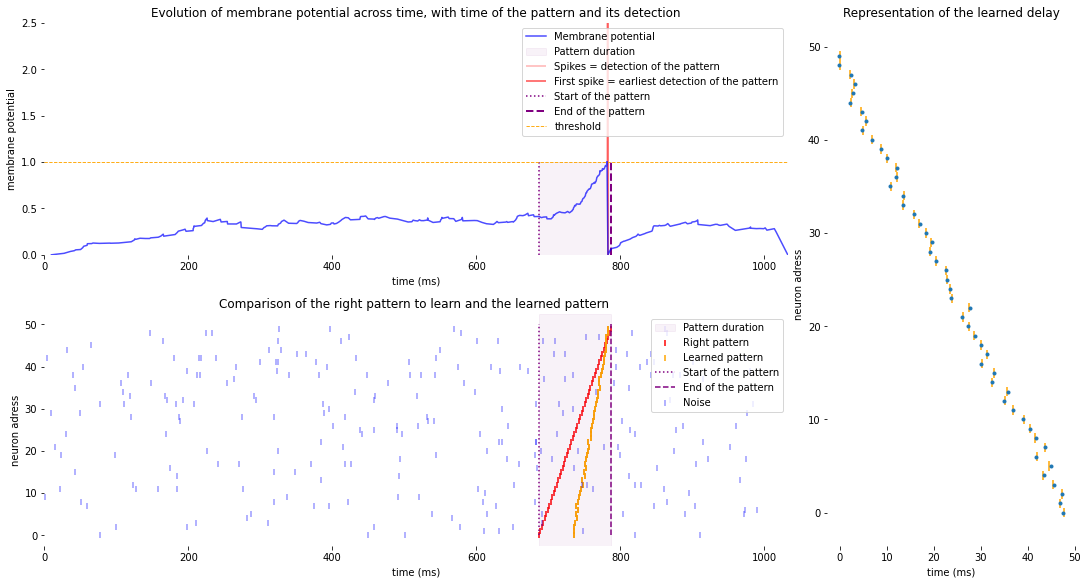

0.8099999999999998


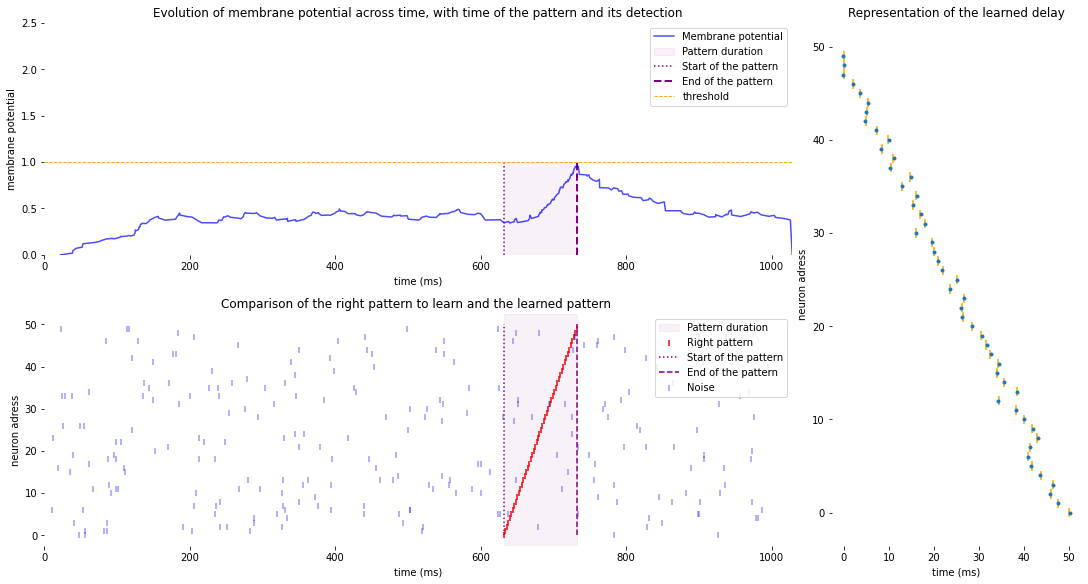

In [11]:
tau = delay_amplitude
gain = 1

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

noise_density =  5e-3
learning_rate_gain = .01
learning_rate_tau = 1
learning_rate_delay = .1
N_epochs = 2001

for i_epoch in range(N_epochs):
    t_true = delay_amplitude + int(np.random.rand()*(simulation_time-3*delay_amplitude))

    aer_noise, aer_pattern, aer = make_input(nb_synapses, noise_density, simulation_time, delay_amplitude, t_true, function = pattern)
    V, sorted_times, sorted_addresses, t_out = N.code(aer)

    output_spikes_number = len(t_out)
    expected_output_spikes = len([t_true])
    
    if output_spikes_number==0:
        N.gain += learning_rate_gain*expected_output_spikes
        #N.tau += learning_rate_tau*expected_output_spikes
    else:
        for t_post in t_out:
            V_out = V[sorted_times==t_post]
            delay_gradient = np.zeros([len(N.delays)])
            for add in range(len(N.delays)):
                spike_times = sorted_times[np.where(sorted_addresses==add)[0]]
                if len(spike_times)>0:
                    delta_delay = t_post-N.delays[add]-spike_times[spike_times<t_post+delay_amplitude]
                    delay_function = np.sign(delta_delay)*absolute_kernel(delta_delay, N.tau)
                    #delay_function = delta_delay*gaussian_kernel(delta_delay, N.tau)
                    delay_gradient[add] = (delay_function).sum()
                
            if np.linalg.norm(delay_gradient)!=0:
                delay_gradient /= np.linalg.norm(delay_gradient)
            N.delays += learning_rate_delay*delay_gradient*delay_amplitude
            N.delays[N.delays<0]=0
        
        N.gain += learning_rate_gain*(expected_output_spikes-(output_spikes_number+1))
        #N.tau += learning_rate_tau*(expected_output_spikes-(output_spikes_number+1))
    if i_epoch % (N_epochs//10) == 0:
        print(N.gain)
        plot_learning_figure(sorted_times, V, N, t_out, t_true, delay_amplitude, aer_noise, aer_pattern, delay_gradient=delay_gradient)

We obtain similar results with the adaptation of the gain. Note that in the formula: 
```
N.gain += learning_rate_gain*(expected_output_spikes-(output_spikes_number+1))
```
The +1 in the end forces the gain to be as small as possible. Same trick is used for the time constant. 

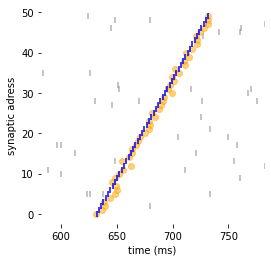

In [14]:
import matplotlib.pyplot as plt

adress_noise, time_noise = aer_noise
adress_pattern, time_pattern = aer_pattern
fig, ax = plt.subplots(figsize = (4, 4))
noise = ax.scatter(time_noise, adress_noise, marker='|', color='grey', alpha = .6, label = 'noise')
delay = ax.scatter(time_pattern.max()-N.delays*2, adress_pattern, marker='o', color='orange', alpha = .5, label = 'matched delay pattern')
pattern = ax.scatter(time_pattern, adress_pattern, marker='|', color='blue', alpha = 1, label = 'pattern');

ax.set(xlim=(time_pattern.min()-50, time_pattern.max()+50))
ax.set_xlabel('time (ms)')
ax.set_ylabel('synaptic adress')
#ax.set_title('neural activity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [15]:
def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = './'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)
printfig(fig, 'linear_motif.pdf')

0.99


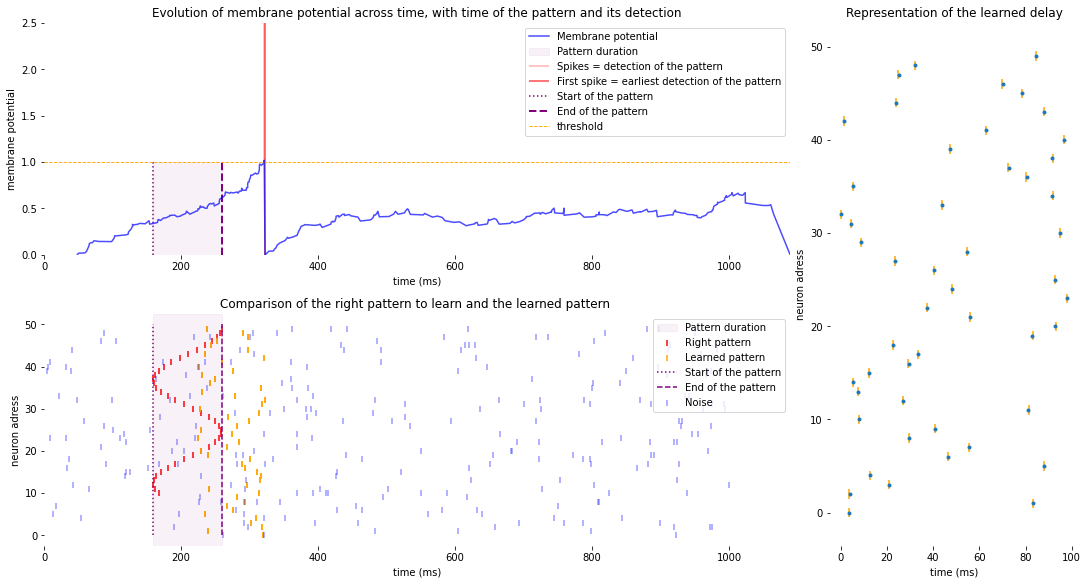

0.9099999999999999


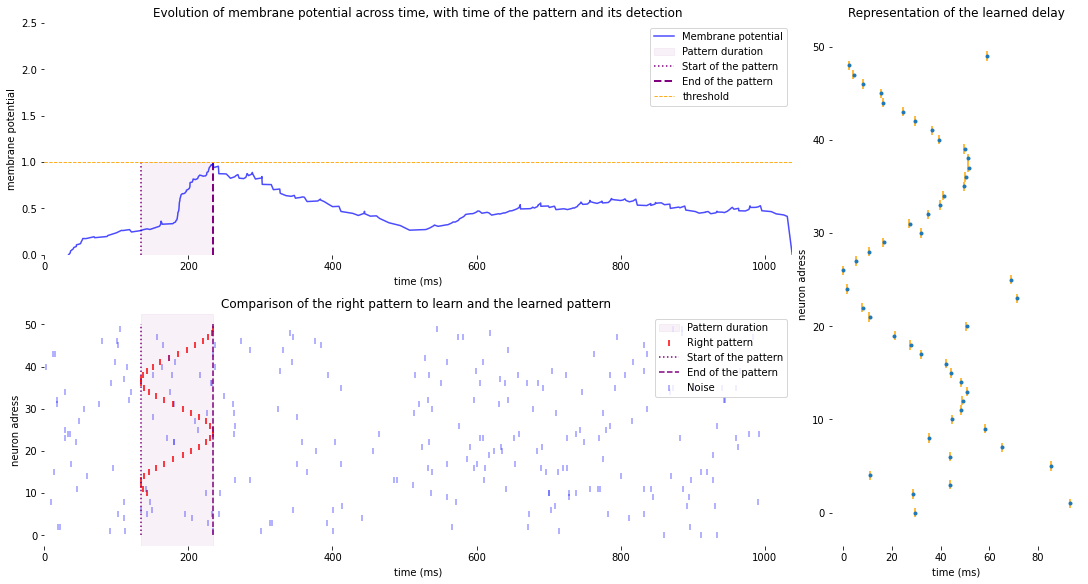

0.8899999999999999


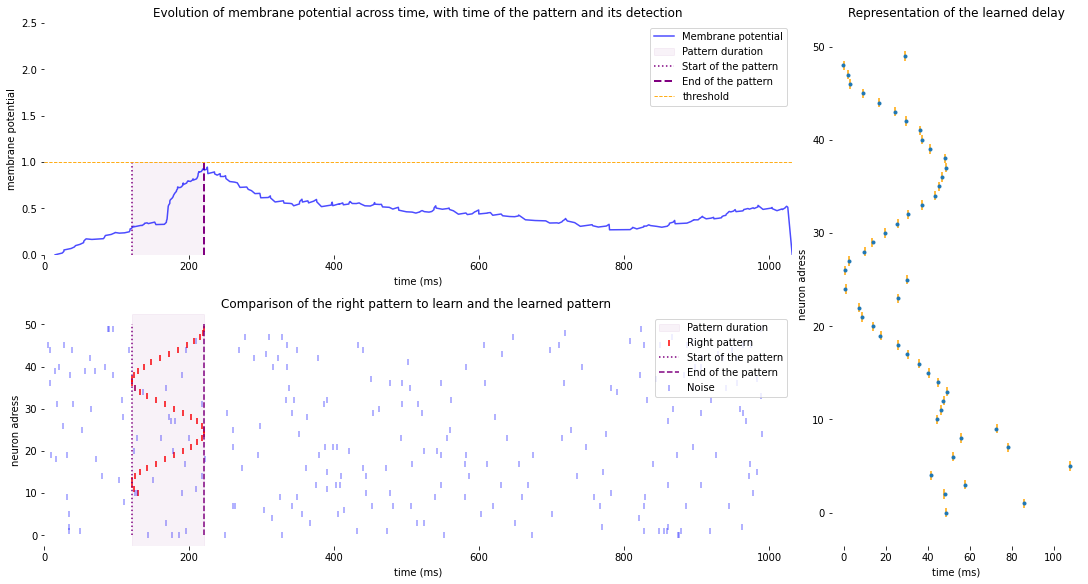

0.8499999999999999


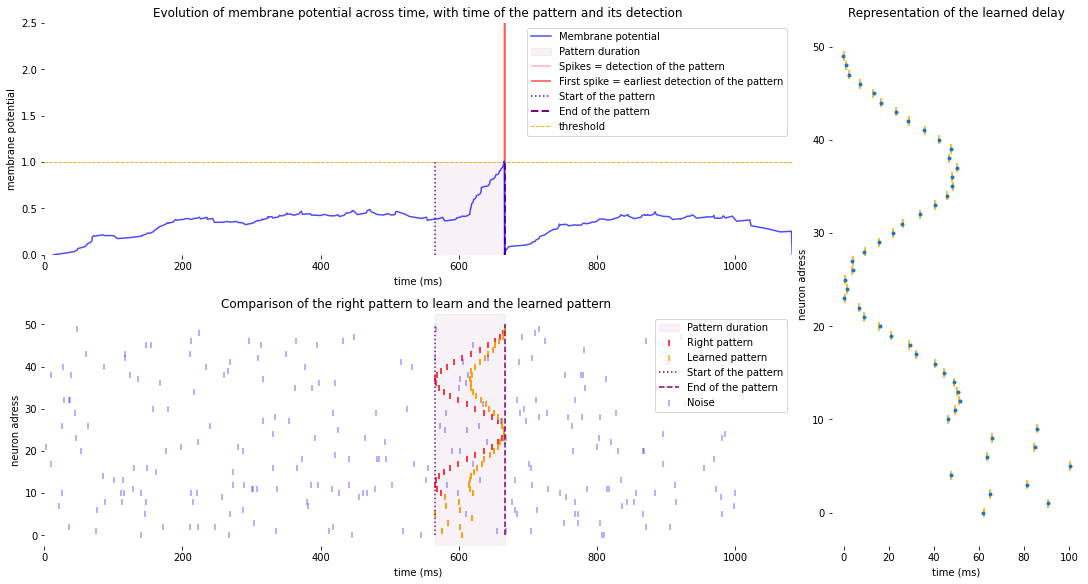

0.8499999999999999


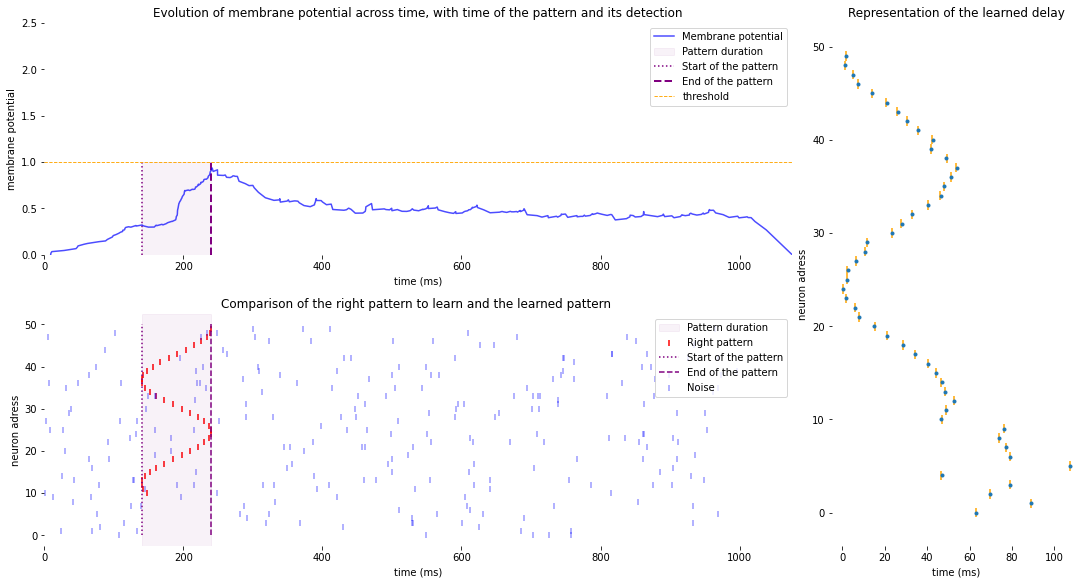

0.8499999999999999


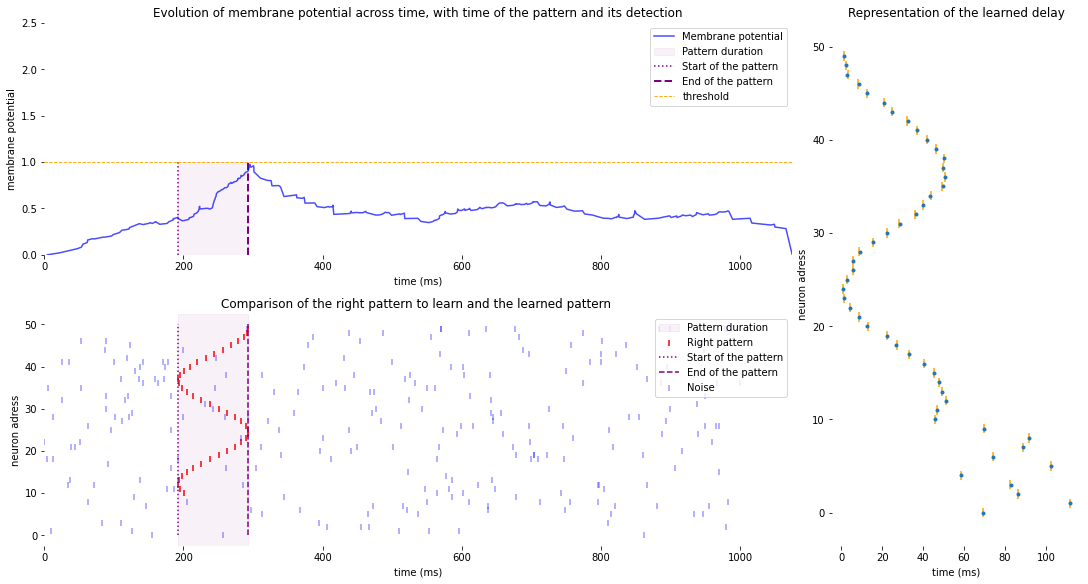

0.8299999999999998


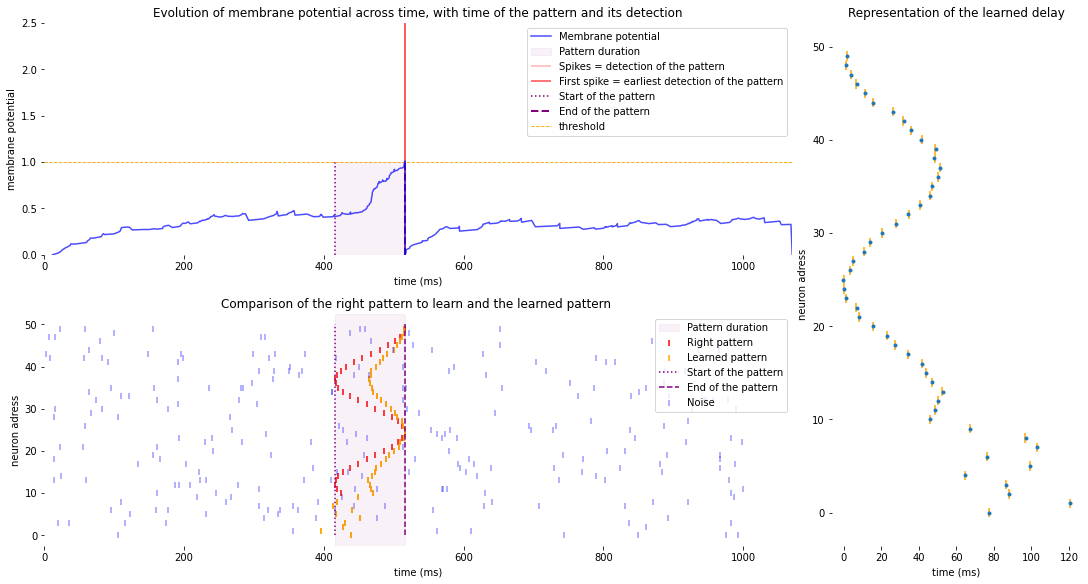

0.8699999999999999


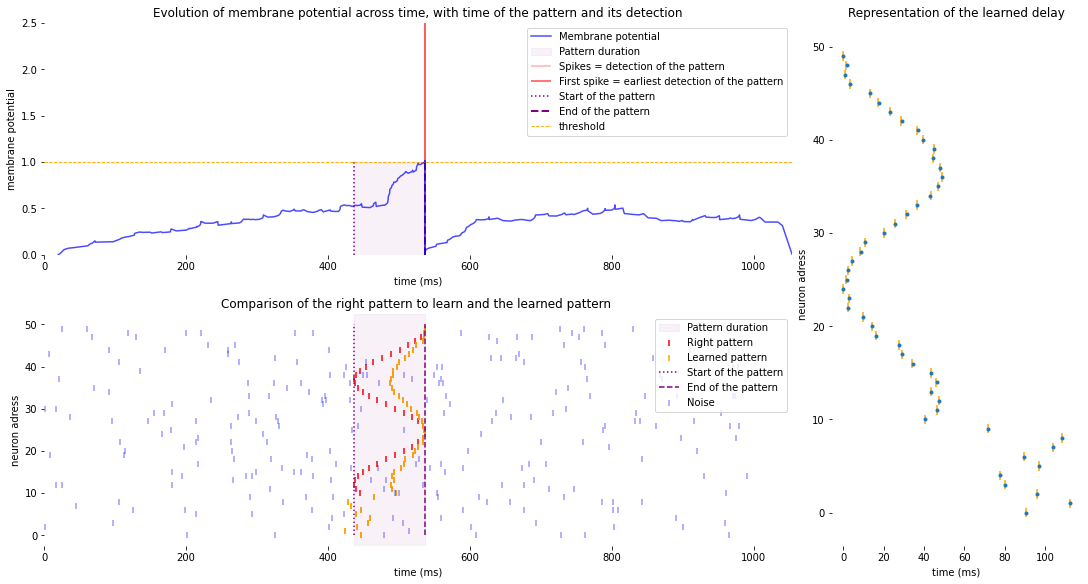

0.8299999999999998


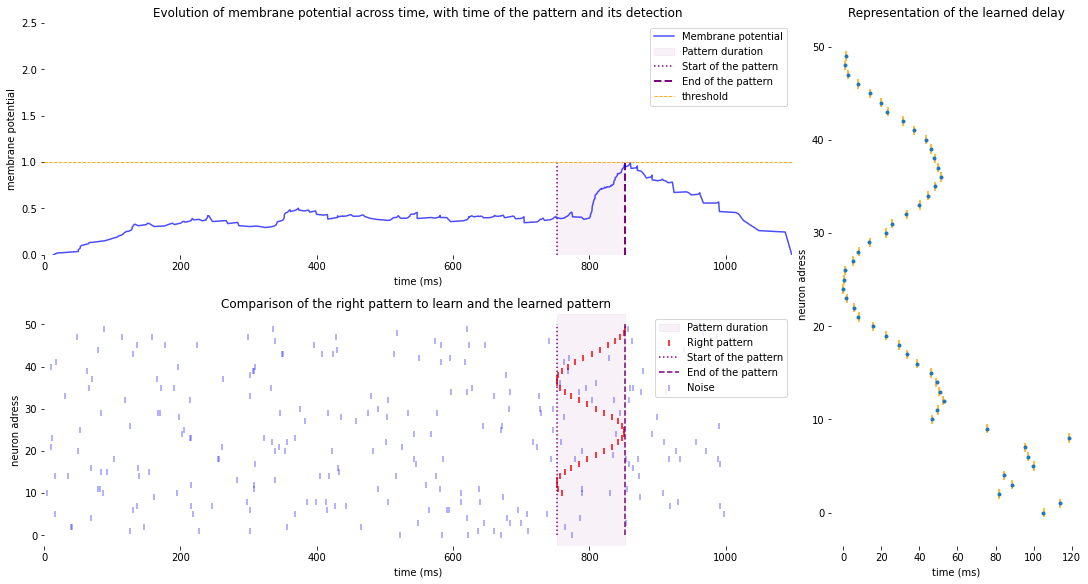

0.8099999999999998


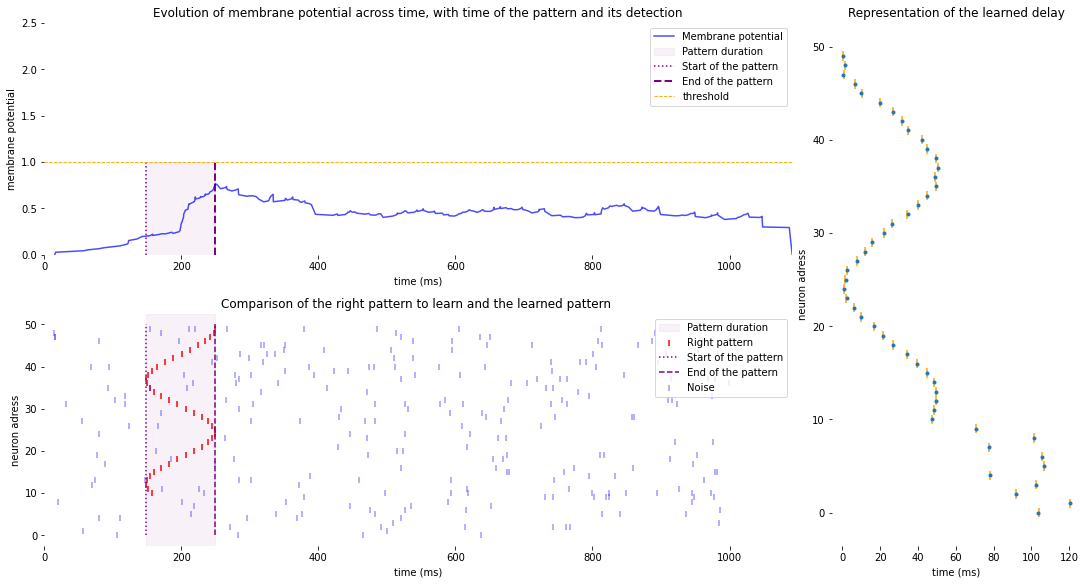

0.8699999999999999


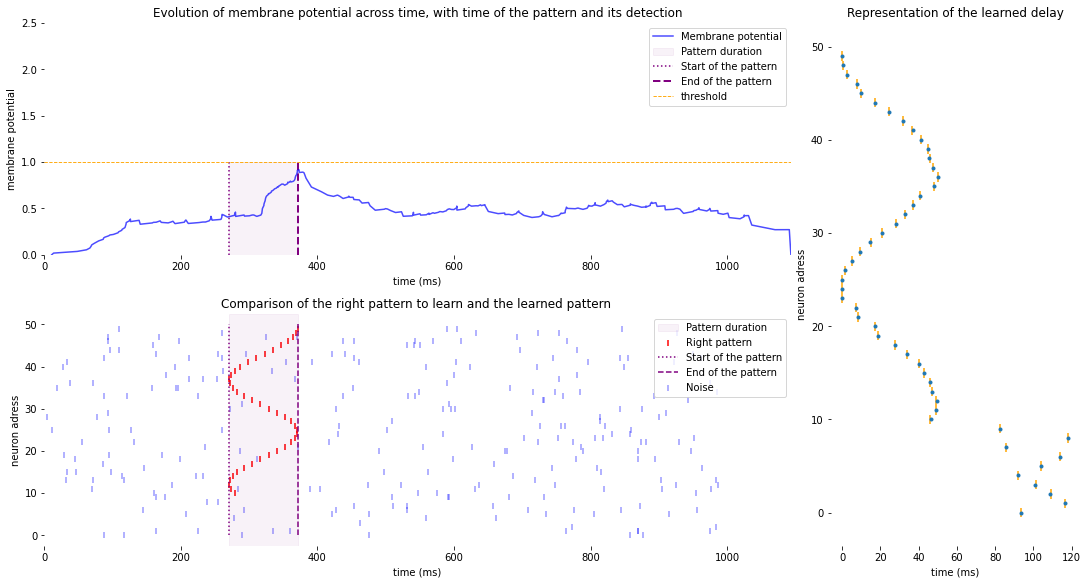

In [8]:
tau = delay_amplitude
gain = 1

N = hsd_neuron(nb_synapses, tau = tau, gain = gain, delay_amplitude = delay_amplitude)

noise_density =  5e-3
learning_rate_gain = .01
learning_rate_tau = 1
learning_rate_delay = .1
learning_rate_weight = .01
N_epochs = 2001

for i_epoch in range(N_epochs):
    t_true = delay_amplitude + int(np.random.rand()*(simulation_time-3*delay_amplitude))

    aer_noise, aer_pattern, aer = make_input(nb_synapses, noise_density, simulation_time, delay_amplitude, t_true, discard_spikes = 10)
    
    V, sorted_times, sorted_addresses, t_out = N.code(aer)

    output_spikes_number = len(t_out)
    expected_output_spikes = len([t_true])
    
    if output_spikes_number==0:
        N.gain += learning_rate_gain*expected_output_spikes
        #N.tau += learning_rate_tau*expected_output_spikes
    else:
        for t_post in t_out:
            V_out = V[sorted_times==t_post]
            delay_gradient = np.zeros([len(N.delays)])
            weight_gradient = np.zeros([len(N.delays)])
            for add in range(len(N.delays)):
                spike_times = sorted_times[np.where(sorted_addresses==add)[0]]
                if len(spike_times)>0:
                    delta_delay = t_post-N.delays[add]-spike_times[spike_times<t_post+delay_amplitude]
                    delay_function = np.sign(delta_delay)*absolute_kernel(delta_delay, N.tau)
                    #delay_function = delta_delay*gaussian_kernel(delta_delay, N.tau)
                    weight_gradient[add] = np.sum(absolute_kernel(delta_delay,N.tau))
                    delay_gradient[add] = (delay_function).sum()
                
            if np.linalg.norm(delay_gradient)!=0:
                delay_gradient /= np.linalg.norm(delay_gradient)
            N.delays += learning_rate_delay*delay_gradient*delay_amplitude
            N.delays[N.delays<0]=0
            
            if np.linalg.norm(weight_gradient)!=0:
                weight_gradient /= np.linalg.norm(weight_gradient)
            N.weights += learning_rate_weight*weight_gradient
            N.weights /= N.weights.sum()
        
        N.gain += learning_rate_gain*(expected_output_spikes-(output_spikes_number+1))
        #N.tau += learning_rate_tau*(expected_output_spikes-(output_spikes_number+1))
    if i_epoch % (N_epochs//10) == 0:
        print(N.gain)
        plot_learning_figure(sorted_times, V, N, t_out, t_true, delay_amplitude, aer_noise, aer_pattern, delay_gradient=delay_gradient)

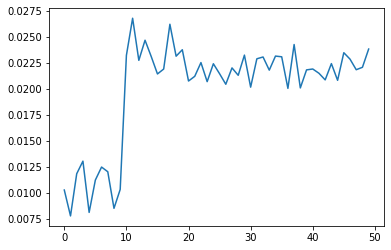

In [10]:
import matplotlib.pyplot as plt
plt.plot(N.weights)

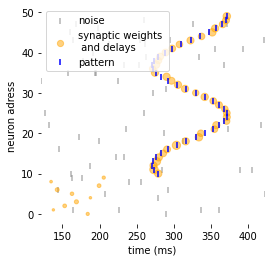

In [26]:
import matplotlib.pyplot as plt

adress_noise, time_noise = aer_noise
adress_pattern, time_pattern = aer_pattern
fig, ax = plt.subplots(figsize = (4, 4))
noise = ax.scatter(time_noise, adress_noise, marker='|', color='grey', alpha = .6, label = 'noise')
delay = ax.scatter(time_pattern.max()-N.delays*2, np.arange(0,len(N.delays)), marker='o', s=100000*N.weights**2, color='orange', alpha = .5, label = 'synaptic weights \n and delays')
pattern = ax.scatter(time_pattern, adress_pattern, marker='|', color='blue', alpha = 1, label = 'pattern');
ax.legend(loc='upper left')
ax.set(xlim=(time_pattern.min()-150, time_pattern.max()+50))
ax.set_xlabel('time (ms)')
ax.set_ylabel('neuron adress')
#ax.set_title('neural activity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [27]:
def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = './'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)
printfig(fig, 'cos_motif_truncated.pdf')